In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys, os
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [3]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")
num_qubits = backend.configuration().num_qubits

In [ ]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

In [11]:
colors = ['grey', 'green', 'crimson', 'cornflowerblue']

In [ ]:
exp_circ = QuantumCircuit(num_qubits, num_qubits)
exp_circ.h(range(num_qubits))
exp_circ.measure(range(num_qubits), range(num_qubits))
exp_circ.barrier()

# Do Not Drive Qubits at the End

In [63]:
sched_list = list(range(num_qubits))

reset_circ = QuantumCircuit(num_qubits)
reset_circ.reset(range(num_qubits))
reset_circ.barrier()

csr_circ = gen_circ(0, num_qubits, qubit_list = sched_list, sched = sched, sched_list = range(num_qubits), num_reset = 1, reset_list = None, add_secure_reset=True, measure = False)
csr_circ.barrier()

measure_circ = QuantumCircuit(num_qubits)
measure_circ.measure_all()

delay_circ = QuantumCircuit(num_qubits)
delay_circ.delay(1000000, range(num_qubits))

exp_circ_list = [
    [exp_circ, measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(reset_circ), measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(csr_circ), measure_circ.compose(delay_circ)]
]
exp_circ_list = [transpile(exp_circs, backend) for exp_circs in exp_circ_list]

## Submit

In [67]:
shots = 1000

In [68]:
# job_id_list = []

# job = backend.run(exp_circ_list[0], shots=shots, memory=True)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[1], shots=shots, rep_delay=0, init_qubits=False, memory=True)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[2], shots=shots, rep_delay=0, init_qubits=False, memory=True)
# job_id_list.append(job.job_id())

# job_id_list

['640777d617598654909794c6',
 '640777d7175986af059794c7',
 '640777d95d83d82231c74eb8']

In [70]:
# job_id_list = ['640777d617598654909794c6',
#  '640777d7175986af059794c7',
#  '640777d95d83d82231c74eb8']
# 
# job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
# save_job(job_list, "data/attack_circuit_no_drive.pickle")

In [ ]:
# job_list = load_job("data/attack_circuit_no_drive.pickle")

In [ ]:
# data_no_drive = [get_cond_count(job) for job in job_list]
# save_job(data_no_drive, "data/attack_circuit_no_drive_data.pickle")

In [ ]:
data_no_drive = load_job("data/attack_circuit_no_drive_data.pickle")

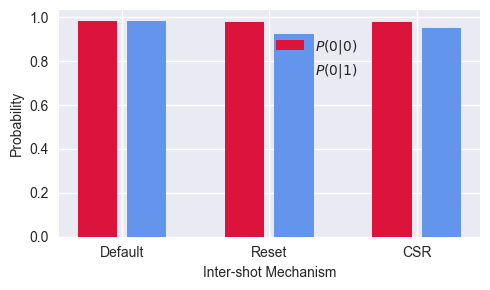

In [72]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

# creating the dataset
fig = plt.figure(figsize = (5, 3), dpi = 100)

width = 1.5
# creating the bar plot
for i, mechanism in enumerate(["Default", "Reset", "CSR"]):
    x = np.array([0, 0.5]) + i * width
    num_0_no_drive = np.sum(data_no_drive[i][0] + data_no_drive[i][1])
    num_1_no_drive = np.sum(data_no_drive[i][2] + data_no_drive[i][3])
    plt.bar(x[0], np.sum(data_no_drive[i][0]) / num_0_no_drive, color = 'crimson', width = 0.4)
    plt.bar(x[1], np.sum(data_no_drive[i][2]) / num_1_no_drive, color = 'cornflowerblue', width = 0.4)

plt.xlabel("Inter-shot Mechanism")
plt.xticks(np.array([0, width, 2 * width]) + 0.25, ["Default", "Reset", "CSR"])
plt.ylabel("Probability")


from matplotlib.patches import Rectangle
handles = [
    Rectangle((0, 0), 1, 0.8, label=r"$P(0|0)$", facecolor = 'crimson'),
    Rectangle((0, 0), 1, 0.8, label=r"$P(0|1)$", facecolor = 'cornflowerblue')
]
fig.legend(handles=handles, fontsize=10, bbox_to_anchor=(0.75, 0.9))

plt.tight_layout()

# plt.savefig("./figs/trojan_no_drive.pdf")

# Drive Qubits at the End

In [47]:
sched_list = list(range(num_qubits))
higher_energy_prep_circ = gen_circ(3, num_qubits, qubit_list = sched_list, sched = sched, sched_list = range(num_qubits), num_reset = 0, reset_list = None, measure = False) 
higher_energy_prep_circ.barrier()

reset_circ = QuantumCircuit(num_qubits)
reset_circ.reset(range(num_qubits))
reset_circ.barrier()

csr_circ = gen_circ(0, num_qubits, qubit_list = sched_list, sched = sched, sched_list = range(num_qubits), num_reset = 1, reset_list = None, add_secure_reset=True, measure = False)
csr_circ.barrier()

measure_circ = QuantumCircuit(num_qubits)
measure_circ.measure_all()

delay_circ = QuantumCircuit(num_qubits)
delay_circ.delay(1000000, range(num_qubits))

exp_circ_list = [
    [exp_circ.copy().compose(higher_energy_prep_circ), measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(higher_energy_prep_circ).compose(reset_circ), measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(higher_energy_prep_circ).compose(csr_circ), measure_circ.compose(delay_circ)]
]
exp_circ_list = [transpile(exp_circs, backend) for exp_circs in exp_circ_list]

## Submit

In [51]:
shots = 1000

In [55]:
# job_id_list = []

# job = backend.run(exp_circ_list[0], shots=shots, memory=True)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[1], shots=shots, rep_delay=0, init_qubits=False, memory=True)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[2], shots=shots, rep_delay=0, init_qubits=False, memory=True)
# job_id_list.append(job.job_id())

# job_id_list

['640774dae023ea2213f3de41',
 '640774dc9602afb7b502161c',
 '640774dd175986f81d9794a7']

In [74]:
# job_id_list = ['6404bec77ad0f90a10a7ffd8',
#  '6404bec92751d56e323a2084',
#  '6404becad299e3357a4b6d4b']

# job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
# save_job(job_list, "data/attack_circuit_drive.pickle")

In [ ]:
# job_list = load_job("data/attack_circuit_drive.pickle")

In [ ]:
# data_drive = [get_cond_count(job) for job in job_list]
# save_job(data_drive, "data/attack_circuit_drive_data.pickle")

In [ ]:
data_drive = load_job("data/attack_circuit_drive_data.pickle")

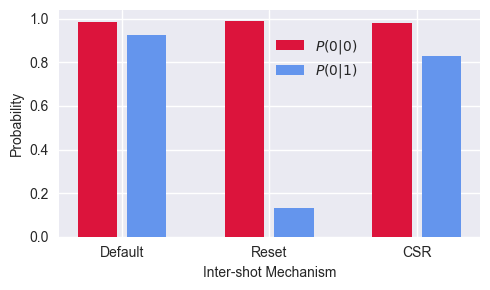

In [76]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

# creating the dataset
fig = plt.figure(figsize = (5, 3), dpi = 100)

width = 1.5
# creating the bar plot
for i, mechanism in enumerate(["Default", "Reset", "CSR"]):
    x = np.array([0, 0.5]) + i * width

    num_0_drive = np.sum(data_drive[i][0] + data_drive[i][1])
    num_1_drive = np.sum(data_drive[i][2] + data_drive[i][3])
    plt.bar(x[0], np.sum(data_drive[i][0]) / num_0_drive, color = 'crimson', width = 0.4)
    plt.bar(x[1], np.sum(data_drive[i][2]) / num_1_drive, color = 'cornflowerblue', width = 0.4)

plt.xlabel("Inter-shot Mechanism")
plt.xticks(np.array([0, width, 2 * width]) + 0.25, ["Default", "Reset", "CSR"])
plt.ylabel("Probability")


from matplotlib.patches import Rectangle
handles = [
    Rectangle((0, 0), 1, 0.8, label=r"$P(0|0)$", facecolor = 'crimson'),
    Rectangle((0, 0), 1, 0.8, label=r"$P(0|1)$", facecolor = 'cornflowerblue')
]
fig.legend(handles=handles, fontsize=10, bbox_to_anchor=(0.75, 0.9))

plt.tight_layout()

# plt.savefig("./figs/trojan_drive.pdf")

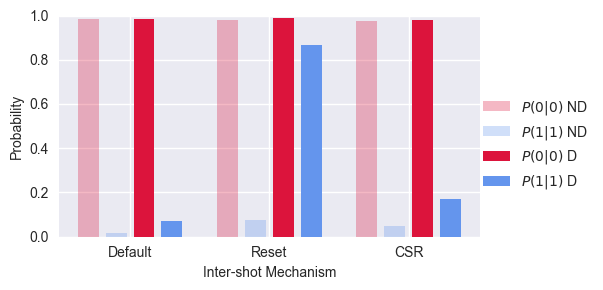

In [77]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

# creating the dataset
fig = plt.figure(figsize = (5, 3), dpi = 100)

width = 1.0
bar_width = 0.15
bar_hatch = 0.3

# creating the bar plot
for i, mechanism in enumerate(["Default", "Reset", "CSR"]):
    x = np.array([-0.3, -0.1, 0.1, 0.3]) + i * width

    num_0_no_drive = np.sum(data_no_drive[i][0] + data_no_drive[i][1])
    num_1_no_drive = np.sum(data_no_drive[i][2] + data_no_drive[i][3])
    plt.bar(x[0], np.sum(data_no_drive[i][0]) / num_0_no_drive, color = 'crimson', alpha = bar_hatch, width = bar_width)
    plt.bar(x[1], np.sum(data_no_drive[i][3]) / num_1_no_drive, color = 'cornflowerblue', alpha = bar_hatch
    , width = bar_width)

    num_0_drive = np.sum(data_drive[i][0] + data_drive[i][1])
    num_1_drive = np.sum(data_drive[i][2] + data_drive[i][3])
    plt.bar(x[2], np.sum(data_drive[i][0]) / num_0_drive, color = 'crimson', width = bar_width)
    plt.bar(x[3], np.sum(data_drive[i][3]) / num_1_drive, color = 'cornflowerblue', width = bar_width)

plt.xlabel("Inter-shot Mechanism")
plt.xticks(np.array([0, width, 2 * width]), ["Default", "Reset", "CSR"])
plt.ylabel("Probability")
plt.ylim((0, 1.0))


from matplotlib.patches import Rectangle
handles = [
    Rectangle((0, 0), 1, 0.8, label=r"$P(0|0)$ ND", facecolor = 'crimson', alpha = bar_hatch),
    Rectangle((0, 0), 1, 0.8, label=r"$P(1|1)$ ND", facecolor = 'cornflowerblue', alpha = bar_hatch),
    Rectangle((0, 0), 1, 0.8, label=r"$P(0|0)$ D", facecolor = 'crimson'),
    Rectangle((0, 0), 1, 0.8, label=r"$P(1|1)$ D", facecolor = 'cornflowerblue')
]
fig.legend(handles=handles, fontsize=10, loc='center left', bbox_to_anchor=(0.95, 0.5))

plt.tight_layout()

# plt.savefig("./figs/trojan.pdf", bbox_inches = "tight")